# Potential Field Example<br>
https://github.com/z-rui/pf/blob/master/pf.py



Calculating the potential field and path planning.

## Dependencies

* Python (tested on 3.5)
* PIL
* numpy

## Files

* `pf.py`: General Operations.
  * Covert a potential field to an image.
  * Path planning.
  * Draw the planned path on the image.
* `epf.py`: A potential field implementation that uses Euclidean distance as potential.
  * One destination.
  * Multiple obstacles.
  * Compute the potential of any point at request.

See `example.py` for usage.

## pf.py

In [1]:
from PIL import Image
import numpy

In [2]:
def field_to_image(f):
    h, w = f.shape
    cached = numpy.array(f, copy=False)
    img = Image.new('RGB', (w, h))
    maxp = minp = 0.0
    for i in range(h):
        for j in range(w):
            val = cached[i, j]
            if not numpy.isinf(val):
                if val > maxp:
                    maxp = val
                elif val < minp:
                    minp = val
    px = img.load()
    for i in range(h):
        for j in range(w):
            val = cached[i, j]
            if numpy.isinf(val):
                px[j, i] = (255, 255, 255)
            elif numpy.abs(val) < 1e-9:
                px[j, i] = (0, 0, 0)
            elif val > 0:
                px[j, i] = (int(val / maxp * 255), 0, 0)
            else:
                px[j, i] = (0, 0, int(val / minp * 255))
    return img

def find_nextstep(f, src):
    h, w = f.shape
    i, j = src
    return min(
        ((i1, j1)
        for i1 in (i-1, i, i+1) if i1 in range(h)
        for j1 in (j-1, j, j+1) if j1 in range(w)
        ), key=lambda x: f[x]
    )

def find_path(f, src, dst=None, maxattempt=None):
    path = [src]
    h, w = f.shape
    if maxattempt is None:
        maxattempt = w*h
    while maxattempt > 0 and src != dst:
        maxattempt -= 1
        src = find_nextstep(f, src)
        path.append(src)
    return path

def draw_path(img, path):
    px = img.load()
    for i, j in path:
        px[j, i] = (0, 255, 0)

## epf.py

In [3]:
from __future__ import division # for Python 2.x compatibility
import numpy

In [4]:
class EuclidField(object):
    p = 5.0
    @staticmethod
    def dist(x, y):
        return numpy.hypot(x[0]-y[0], x[1]-y[1])
    def __init__(self, size, dst, obstacles):
        w, h = size
        self.shape = (h, w)
        self.dst = dst
        self.obstacles = obstacles
    def __getitem__(self, q):
        i, j = q
        h, w = self.shape
        if not (i in range(h) and j in range(w)):
            raise IndexError
        base = self.dist(q, self.dst)
        k = 0.0
        p = self.p
        for obj in self.obstacles:
            dist_to_obj = self.dist(q, obj)
            if dist_to_obj <= p:
                k += 5.0 / (1+(dist_to_obj/2.0)**6)
        return (1.0 + k) * base**2
    def __array__(self):
        h, w = self.shape
        return numpy.array([[self[i, j] for j in range(w)] for i in range(h)])

## example.py

In [5]:
import pf
import epf

In [6]:
f = epf.EuclidField(
    (50, 50),   # width and height
    (7, 14),    # goal
    [           # obstacles
        (9, 5),
        (10, 4),
        (10, 5),
        (10, 6),
        (11, 5),

        (9, 15),
        (10, 14),
        (10, 15),
        (10, 16),
        (11, 15),

        (39, 10),
        (40, 9),
        (40, 10),
        (40, 11),
        (41, 10),
    ]
)
src = (46, 5)

In [8]:
f.obstacles 

[(9, 5),
 (10, 4),
 (10, 5),
 (10, 6),
 (11, 5),
 (9, 15),
 (10, 14),
 (10, 15),
 (10, 16),
 (11, 15),
 (39, 10),
 (40, 9),
 (40, 10),
 (40, 11),
 (41, 10)]

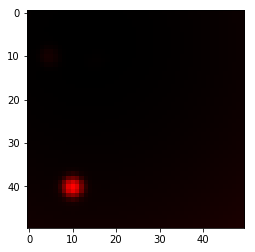

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

path = pf.find_path(f, src, f.dst, 100)
img = pf.field_to_image(f)
# pf.draw_path(img, path)
plt.imshow(img)
# im.save('out.png')